In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [27]:
b_size  = 32
img_size = 256
channel = 3
epoch = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    seed=42,
    batch_size=b_size,
    image_size=(img_size,img_size),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [4]:
dataset.class_names[1]

'Potato___Late_blight'

In [5]:
len(dataset)

68

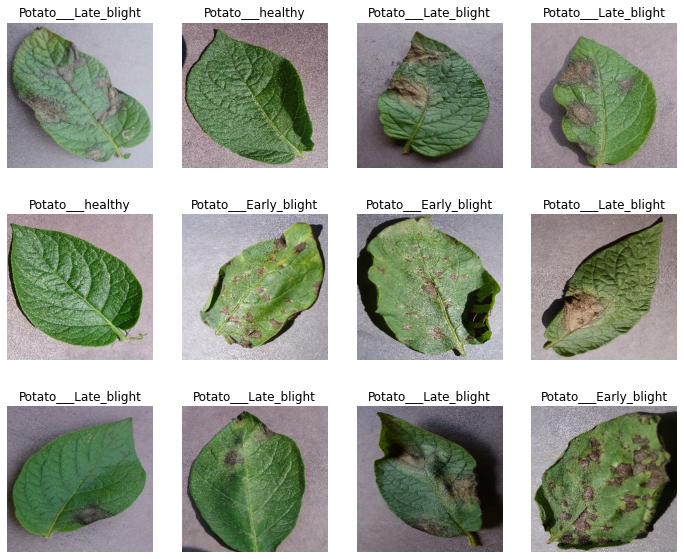

In [6]:
plt.figure(figsize=(12,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis('off')


In [7]:
def data_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split +val_split + test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)

    return train_ds, test_ds, val_ds

In [8]:
train_ds, test_ds, val_ds = data_partition(dataset)

print(len(train_ds))
print(len(test_ds))
print(len(test_ds))

54
6
6


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [11]:
data_augmantation  = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (b_size, img_size, img_size, channel)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size= (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,  kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    batch_size=b_size,
    validation_data= val_ds,
    verbose=1,
    epochs=20
)

Epoch 1/20
54/54 [==============================] - 171s 3s/step - loss: 0.8655 - accuracy: 0.5243 - val_loss: 0.8952 - val_accuracy: 0.5078
Epoch 2/20
54/54 [==============================] - 167s 3s/step - loss: 0.7367 - accuracy: 0.6725 - val_loss: 0.5587 - val_accuracy: 0.7617
Epoch 3/20
54/54 [==============================] - 157s 3s/step - loss: 0.4554 - accuracy: 0.8177 - val_loss: 0.3488 - val_accuracy: 0.8516
Epoch 4/20
54/54 [==============================] - 641s 12s/step - loss: 0.2610 - accuracy: 0.9028 - val_loss: 0.3258 - val_accuracy: 0.9062
Epoch 5/20
54/54 [==============================] - 155s 3s/step - loss: 0.2480 - accuracy: 0.9074 - val_loss: 0.1163 - val_accuracy: 0.9766
Epoch 6/20
54/54 [==============================] - 136s 3s/step - loss: 0.1123 - accuracy: 0.9595 - val_loss: 0.1044 - val_accuracy: 0.9688
Epoch 7/20
54/54 [==============================] - 183s 3s/step - loss: 0.0782 - accuracy: 0.9699 - val_loss: 0.0524 - val_accuracy: 0.9844
Epoch 8/20
5

In [21]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [22]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 9s 561ms/step - loss: 0.0027 - accuracy: 1.0000


In [23]:
len(history.history['loss'])

20

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

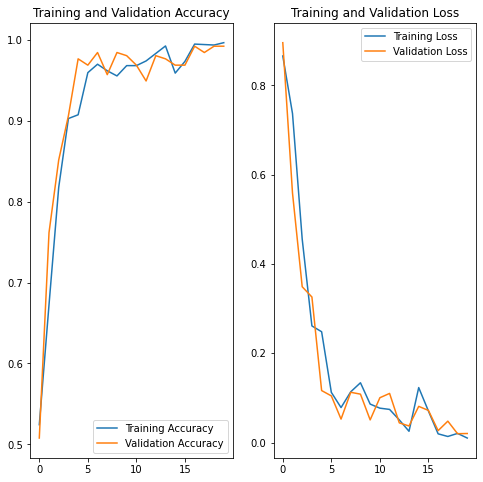

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), acc, label='Training Accuracy')
plt.plot(range(epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 572ms/step
predicted label: Potato___Early_blight


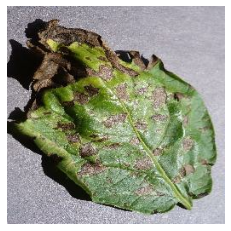

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    print("actual label:",dataset.class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",dataset.class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = dataset.class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


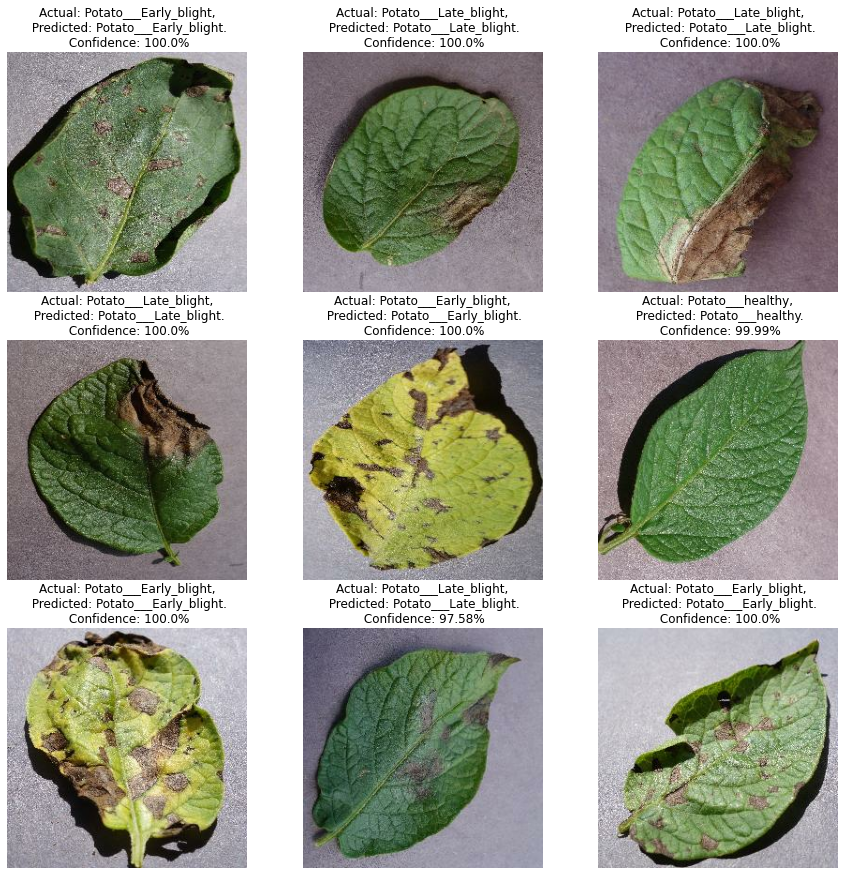

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = dataset.class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")